In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

2023-10-06 10:12:24.596009: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
DATA_READERS = {
    "edf": mne.io.read_raw_edf,
}

def load_psg_sample(data_files, data_reader, picks=None):
    raw_data = data_reader(
        data_files[0], stim_channel="Event marker", infer_types=True, preload=True
    )

    annot_data = mne.read_annotations(data_files[1])
    raw_data.set_annotations(annot_data, emit_warning=False)
    if picks:
        raw_data.pick(picks)

    return raw_data, annot_data


In [60]:
n_subjects = 2
subject_ids = list(range(n_subjects))
sleep_data_files = fetch_data(subjects=subject_ids, recording=[1])

data_format = "edf"
channel = "Fpz-Cz"

Using default location ~/mne_data for PHYSIONET_SLEEP...


In [305]:
sleep_data_files

[['/Users/maxverbiest/mne_data/physionet-sleep-data/SC4001E0-PSG.edf',
  '/Users/maxverbiest/mne_data/physionet-sleep-data/SC4001EC-Hypnogram.edf'],
 ['/Users/maxverbiest/mne_data/physionet-sleep-data/SC4011E0-PSG.edf',
  '/Users/maxverbiest/mne_data/physionet-sleep-data/SC4011EH-Hypnogram.edf']]

In [32]:
raw_train, annotations_train = load_psg_sample(sleep_data_files[0], DATA_READERS[data_format], picks=channel)
raw_test, annotations_test = load_psg_sample(sleep_data_files[1], DATA_READERS[data_format], picks=channel)

Extracting EDF parameters from /Users/maxverbiest/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'Resp oro-nasal' recognized as type RESP (renamed to 'oro-nasal').
Channel 'EMG submental' recognized as type EMG (renamed to 'submental').
Channel 'Temp rectal' recognized as type TEMP (renamed to 'rectal').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Extracting EDF parameters from /Users/maxverbiest/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Channel 'EEG Fpz-Cz' recognized as type EEG (renamed to 'Fpz-Cz').
Channel 'EEG Pz-Oz' recognized as type EEG (renamed to 'Pz-Oz').
Channel 'EOG horizontal' recognized as type EOG (renamed to 'horizontal').
Channel 'R

In [37]:
annotation_desc_2_event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annotations_train.crop(annotations_train[1]["onset"] - (30 * 60), annotations_train[-2]["onset"] + (30 * 60))
raw_train.set_annotations(annotations_train, emit_warning=False)
events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)

annotations_test.crop(annotations_test[1]["onset"] - (30 * 60), annotations_test[-2]["onset"] + (30 * 60))
raw_test.set_annotations(annotations_test, emit_warning=False)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


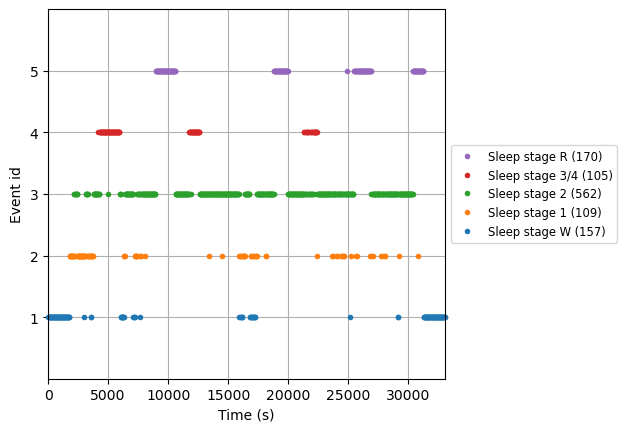

In [38]:
# create a new event_id that unifies stages 3 and 4
event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3/4": 4,
    "Sleep stage R": 5,
}

# plot events
fig = mne.viz.plot_events(
    events_test,
    event_id=event_id,
    sfreq=raw_test.info["sfreq"],
    first_samp=events_test[0, 0],
)

# keep the color-code for further plotting
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [39]:
tmax = 30.0 - (1.0 / raw_train.info["sfreq"])  # tmax is included

epochs_train = mne.Epochs(
    raw=raw_train,
    events=events_train,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
del raw_train

epochs_test = mne.Epochs(
    raw=raw_test,
    events=events_test,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
del raw_test

print(epochs_train)

Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  841 events (good & bad), 0 – 29.99 s, baseline off, ~7 kB, data not loaded,
 'Sleep stage W': 188
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125>


Using data from preloaded Raw for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Using data from preloaded Raw for 109 events and 3000 origina

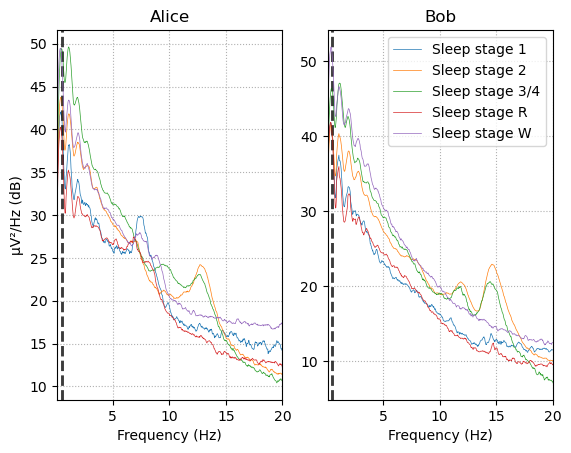

In [40]:
# visualize Alice vs. Bob PSD by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2], ["Alice", "Bob"], [epochs_train, epochs_test]):
    for stage, color in zip(stages, stage_colors):
        spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=20.0)
        spectrum.plot(
            ci=None,
            color=color,
            axes=ax,
            show=False,
            average=True,
            spatial_colors=False,
            picks="data",
            exclude="bads",
        )
    ax.set(title=title, xlabel="Frequency (Hz)")
ax1.set(ylabel="µV²/Hz (dB)")
ax2.legend(ax2.lines[2::3], stages)
plt.show()

In [129]:
def eeg_power_band(epochs, picks):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5] -> actually [n_samples, 5 * n_traces], [[eeg1_fb1, eeg2_fb1 ..., eeg1_fbn, eeg2_fbn, ...], ...]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks=picks, fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [144]:
X_train = eeg_power_band(epochs_train, picks=channel).reshape(len(epochs_train), 5, 1)
y_train = epochs_train.events[:, 2]

X_test = eeg_power_band(epochs_test, picks=channel).reshape(len(epochs_test), 5, 1)
y_test = epochs_test.events[:, 2]

Using data from preloaded Raw for 841 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 1103 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


In [304]:
epochs_train.get_data().reshape(len(epochs_train), 3000).shape

Using data from preloaded Raw for 841 events and 3000 original time points ...


(841, 3000)

In [297]:
epochs_train.get_data().shape

Using data from preloaded Raw for 841 events and 3000 original time points ...


(841, 1, 3000)

In [293]:
model = models.Sequential()

model.add(layers.Conv1D(20, 40, activation='relu', input_shape=(100, 3000, 1)))
model.add(layers.MaxPooling2D((20, 1)))
model.add(layers.Conv1D(20, 30, activation='relu'))
model.add(layers.MaxPooling2D((5, 1)))

model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(5))

model.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_73 (Conv1D)          (None, 100, 2961, 20)     820       
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 5, 2961, 20)      0         
 g2D)                                                            
                                                                 
 conv1d_74 (Conv1D)          (None, 5, 2932, 20)       12020     
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 1, 2932, 20)      0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 58640)             0         
                                                                 
 dense_19 (Dense)            (None, 50)              

In [267]:
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 100, 2961, 20)     820       
                                                                 
Total params: 820
Trainable params: 820
Non-trainable params: 0
_________________________________________________________________


In [246]:
model = models.Sequential()

model.add(layers.Conv2D(20, (40, 5), activation='relu', input_shape=(841, 5, 1)))
model.add(layers.MaxPooling2D((20, 1)))
model.add(layers.Conv2D(40, (20, 1), activation='relu'))
model.add(layers.MaxPooling2D((10, 1)))

model.add(layers.Flatten())
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(5))

In [294]:
X_train.shape

(841, 5, 1)

In [146]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10


ValueError: in user code:

    File "/Users/maxverbiest/miniconda3/envs/EEG-for-DSS/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/maxverbiest/miniconda3/envs/EEG-for-DSS/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/maxverbiest/miniconda3/envs/EEG-for-DSS/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/maxverbiest/miniconda3/envs/EEG-for-DSS/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/maxverbiest/miniconda3/envs/EEG-for-DSS/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/maxverbiest/miniconda3/envs/EEG-for-DSS/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_19" is incompatible with the layer: expected shape=(None, 841, 5, 1), found shape=(None, 5, 1)
